# データセットの改修

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_unimol = pd.read_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset.csv')
df_unimol

,REF-CID,PRB-CID,AID,TID,CUT_NUM,COMMON_FRAG,REF-FRAG,PRB-FRAG,SMIRKS,REF-FRAG_heavy,PRB-FRAG_heavy,VAR_heavy_sum,REF-standard_value,REF-SMILES,STANDARD_TYPE,PRB-standard_value,PRB-SMILES,delta_value,label_bin
0,CHEMBL13920,CHEMBL13878,168,CHEMBL312,3,[10*]C.[10*]C.[5*]CCCC#C,[4*]C(=O)c1cc(C([11*])([12*])C)c2c(c1)C(C)(C)CO2,[4*]C(=O)c1cc(C([11*])([12*])C)c(O)c(C(C)(C)C)c1,[[10*]C.[10*]C.[5*]CCCC#C]>>[[4*]C(=O)c1cc(C([...,15,15,30,6000.00,C#CCCCC(=O)c1cc(C(C)(C)C)c2c(c1)C(C)(C)CO2,IC50,3000.00,C#CCCCC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,0.301030,False
1,CHEMBL59166,CHEMBL293944,365,CHEMBL3247,2,[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@@...,[19*]C([22*])O,[19*]C([22*])=O,[[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@...,2,2,4,1.60,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,IC50,1.00,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,0.204120,True
2,CHEMBL61702,CHEMBL58289,365,CHEMBL3247,2,[19*]CC[C@@H]1C2C(=CCC[C@@H]2OC(=O)[C@@H](C)CC...,[18*]C([21*])=O,[18*]C([21*])O,[[19*]CC[C@@H]1C2C(=CCC[C@@H]2OC(=O)[C@@H](C)C...,2,2,4,32.00,CC[C@H](C)C(=O)O[C@H]1CCC=C2C=C[C@H](C)[C@H](C...,IC50,13.00,CC[C@H](C)C(=O)O[C@H]1CCC=C2C=C[C@H](C)[C@H](C...,0.391207,False
3,CHEMBL116735,CHEMBL325516,685,CHEMBL214,1,[2*]C(=O)N1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1,[1*]CCc1ccc(F)cc1,[1*]OCCc1ccc(F)cc1,[[2*]C(=O)N1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)C...,9,10,19,1110.00,O=C(CCc1ccc(F)cc1)N1CCN(CCCC(c2ccc(F)cc2)c2ccc...,IC50,1140.00,O=C(OCCc1ccc(F)cc1)N1CCN(CCCC(c2ccc(F)cc2)c2cc...,-0.011582,True
4,CHEMBL135076,CHEMBL133455,691,CHEMBL214,3,[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N,*[C@@H]([2*])[3*],*[C@H]([2*])[3*],[[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N]>>[...,1,1,2,8650.00,C[C@@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,IC50,10000.00,C[C@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,-0.062984,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779076,CHEMBL301106,CHEMBL292899,2364482,CHEMBL1978,1,[7*]C1CCCc2ncccc21,[6*]CCCn1ccnc1,[6*]CCn1ccnc1,[[7*]C1CCCc2ncccc21]>>[[6*]CCCn1ccnc1]|[[6*]CC...,8,7,15,349.95,c1cnc2c(c1)C(CCCn1ccnc1)CCC2,IC50,380.19,c1cnc2c(c1)C(CCn1ccnc1)CCC2,-0.035995,True
779077,CHEMBL492818,CHEMBL45068,2364482,CHEMBL1978,1,[2*]C(=O)c1c(O)cc(O)cc1O,[1*]CCc1ccc(O)c(O)c1,[1*]CCc1ccc(O)cc1,[[2*]C(=O)c1c(O)cc(O)cc1O]>>[[1*]CCc1ccc(O)c(O...,10,9,19,2798.98,O=C(CCc1ccc(O)c(O)c1)c1c(O)cc(O)cc1O,IC50,2600.16,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,0.032000,True
779078,CHEMBL250489,CHEMBL250490,2367747,CHEMBL5366,1,[7*]CCCc1nc2c(Cl)cccc2c(=O)[nH]1,[6*]N1CCC(c2ccccc2)CC1,[6*]N1CCC(c2ccc(F)cc2)CC1,[[7*]CCCc1nc2c(Cl)cccc2c(=O)[nH]1]>>[[6*]N1CCC...,12,13,25,610.00,O=c1[nH]c(CCCN2CCC(c3ccccc3)CC2)nc2c(Cl)cccc12,IC50,500.00,O=c1[nH]c(CCCN2CCC(c3ccc(F)cc3)CC2)nc2c(Cl)cccc12,0.086360,True
779079,CHEMBL1334633,CHEMBL1334684,2380158,CHEMBL6026,2,[1*]O[3*].[2*]C(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,[2*]CC,[2*]C1CCCCC1,[[1*]O[3*].[2*]C(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)...,2,6,8,8000.00,CCOC(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,IC50,8000.00,O=C(OC1CCCCC1)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,0.000000,True


## （blankつける）

In [8]:
#df_unimolのdelta_valueの絶対値がが0.3~0.5の行を削除
df_filtered = df_unimol[~df_unimol['delta_value'].abs().between(0.3, 0.5)]

df_filtered.to_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_blank.csv', index=False)

In [9]:
df_filtered

,REF-CID,PRB-CID,AID,TID,CUT_NUM,COMMON_FRAG,REF-FRAG,PRB-FRAG,SMIRKS,REF-FRAG_heavy,PRB-FRAG_heavy,VAR_heavy_sum,REF-standard_value,REF-SMILES,STANDARD_TYPE,PRB-standard_value,PRB-SMILES,delta_value,label_bin
1,CHEMBL59166,CHEMBL293944,365,CHEMBL3247,2,[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@@...,[19*]C([22*])O,[19*]C([22*])=O,[[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@...,2,2,4,1.60,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,IC50,1.00,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,0.204120,True
3,CHEMBL116735,CHEMBL325516,685,CHEMBL214,1,[2*]C(=O)N1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1,[1*]CCc1ccc(F)cc1,[1*]OCCc1ccc(F)cc1,[[2*]C(=O)N1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)C...,9,10,19,1110.00,O=C(CCc1ccc(F)cc1)N1CCN(CCCC(c2ccc(F)cc2)c2ccc...,IC50,1140.00,O=C(OCCc1ccc(F)cc1)N1CCN(CCCC(c2ccc(F)cc2)c2cc...,-0.011582,True
4,CHEMBL135076,CHEMBL133455,691,CHEMBL214,3,[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N,*[C@@H]([2*])[3*],*[C@H]([2*])[3*],[[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N]>>[...,1,1,2,8650.00,C[C@@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,IC50,10000.00,C[C@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,-0.062984,True
5,CHEMBL440461,CHEMBL20599,728,CHEMBL215,1,[16*]Oc1cc(F)cc([C@](CC)(OC)C(=O)OC)c1,[15*]Cc1ccc2c(ccc(=O)n2C)c1,[15*]Cc1ccc2ccccc2c1,[[16*]Oc1cc(F)cc([C@](CC)(OC)C(=O)OC)c1]>>[[15...,13,11,24,340.00,CC[C@@](OC)(C(=O)OC)c1cc(F)cc(OCc2ccc3c(ccc(=O...,IC50,330.00,CC[C@@](OC)(C(=O)OC)c1cc(F)cc(OCc2ccc3ccccc3c2)c1,0.012965,True
7,CHEMBL442334,CHEMBL21987,728,CHEMBL215,3,[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC,[1*][C@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[1*][C@@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC]>>[...,14,14,28,410.00,CC[C@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)c...,IC50,4500.00,CC[C@@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)...,-1.040429,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779076,CHEMBL301106,CHEMBL292899,2364482,CHEMBL1978,1,[7*]C1CCCc2ncccc21,[6*]CCCn1ccnc1,[6*]CCn1ccnc1,[[7*]C1CCCc2ncccc21]>>[[6*]CCCn1ccnc1]|[[6*]CC...,8,7,15,349.95,c1cnc2c(c1)C(CCCn1ccnc1)CCC2,IC50,380.19,c1cnc2c(c1)C(CCn1ccnc1)CCC2,-0.035995,True
779077,CHEMBL492818,CHEMBL45068,2364482,CHEMBL1978,1,[2*]C(=O)c1c(O)cc(O)cc1O,[1*]CCc1ccc(O)c(O)c1,[1*]CCc1ccc(O)cc1,[[2*]C(=O)c1c(O)cc(O)cc1O]>>[[1*]CCc1ccc(O)c(O...,10,9,19,2798.98,O=C(CCc1ccc(O)c(O)c1)c1c(O)cc(O)cc1O,IC50,2600.16,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,0.032000,True
779078,CHEMBL250489,CHEMBL250490,2367747,CHEMBL5366,1,[7*]CCCc1nc2c(Cl)cccc2c(=O)[nH]1,[6*]N1CCC(c2ccccc2)CC1,[6*]N1CCC(c2ccc(F)cc2)CC1,[[7*]CCCc1nc2c(Cl)cccc2c(=O)[nH]1]>>[[6*]N1CCC...,12,13,25,610.00,O=c1[nH]c(CCCN2CCC(c3ccccc3)CC2)nc2c(Cl)cccc12,IC50,500.00,O=c1[nH]c(CCCN2CCC(c3ccc(F)cc3)CC2)nc2c(Cl)cccc12,0.086360,True
779079,CHEMBL1334633,CHEMBL1334684,2380158,CHEMBL6026,2,[1*]O[3*].[2*]C(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,[2*]CC,[2*]C1CCCCC1,[[1*]O[3*].[2*]C(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)...,2,6,8,8000.00,CCOC(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,IC50,8000.00,O=C(OC1CCCCC1)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,0.000000,True


# FRAGごとのラベリング（そもそも今の評価のコードが単一ラベルになっているか確認）

In [10]:
import re

def normalize_frag(frag_str):
    """
    フラグメント文字列からダミー原子のインデックスを正規化する
    例: [4*] -> [*], [11*] -> [*], [12*] -> [*]
    """
    if pd.isna(frag_str):
        return frag_str
    # ダミー原子のパターン（[数字*]）を[*]に置換
    normalized = re.sub(r'\[\d+\*\]', '[*]', str(frag_str))
    return normalized

# REF-FRAGとPRB-FRAGを正規化
df_unimol['REF-FRAG_normalized'] = df_unimol['REF-FRAG'].apply(normalize_frag)
df_unimol['PRB-FRAG_normalized'] = df_unimol['PRB-FRAG'].apply(normalize_frag)

# 正規化されたFRAGペアでグループ化してlabel_binの一貫性をチェック
grouped_frag = df_unimol.groupby(['REF-FRAG_normalized', 'PRB-FRAG_normalized'])['label_bin'].nunique().reset_index()
inconsistent_pairs_frag = grouped_frag[grouped_frag['label_bin'] > 1][['REF-FRAG_normalized', 'PRB-FRAG_normalized']]

print(f"非一貫なFRAGペア数: {len(inconsistent_pairs_frag)}")
print("非一貫なFRAGペア:")
print(inconsistent_pairs_frag)

# 非一貫なペアを持つ行を削除
df_consistent_frag = df_unimol.merge(
    inconsistent_pairs_frag, 
    on=['REF-FRAG_normalized', 'PRB-FRAG_normalized'], 
    how='left', 
    indicator=True
)
df_consistent_frag = df_consistent_frag[df_consistent_frag['_merge'] == 'left_only'].drop(columns=['_merge'])

print(f"\n元のデータ行数: {len(df_unimol)}")
print(f"フィルタ後の行数: {len(df_consistent_frag)}")
print(f"削除された行数: {len(df_unimol) - len(df_consistent_frag)}")

# 正規化用の列を削除（必要に応じて）
df_consistent_frag = df_consistent_frag.drop(columns=['REF-FRAG_normalized', 'PRB-FRAG_normalized'])

display(df_consistent_frag.head())

非一貫なFRAGペア数: 74837
非一貫なFRAGペア:
                     REF-FRAG_normalized            PRB-FRAG_normalized
62      */C(=N\N([*])C)c1ccc(C(=O)NO)cc1  */C(=N\N[*])c1ccc(C(=O)NO)cc1
333                 */C(=N\N[*])c1ccccc1       */C(=N\N[*])c1ccc(Cl)cc1
384                       */C=C/C([*])=O               [*]C(=C)C([*])=O
397                           */C=C/C[*]                       *C#CC[*]
398                           */C=C/C[*]                        *CCC[*]
...                                  ...                            ...
484172             [*][S+]([O-])c1ccccc1                   [*]Sc1ccccc1
484198                 [*][S@+]([*])[O-]                [*]S([*])(=O)=O
484199                 [*][S@+]([*])[O-]             [*][S@@+]([*])[O-]
484200      [*][S@+]([O-])c1ccc(O[*])cc1  [*][S@@+]([O-])c1ccc(O[*])cc1
484205     [*][S@@+]([O-])c1ccc(O[*])cc1   [*][S@+]([O-])c1ccc(O[*])cc1

[74837 rows x 2 columns]

元のデータ行数: 779081
フィルタ後の行数: 496323
削除された行数: 282758

元のデータ行数: 779081
フィルタ後の行数: 49

,REF-CID,PRB-CID,AID,TID,CUT_NUM,COMMON_FRAG,REF-FRAG,PRB-FRAG,SMIRKS,REF-FRAG_heavy,PRB-FRAG_heavy,VAR_heavy_sum,REF-standard_value,REF-SMILES,STANDARD_TYPE,PRB-standard_value,PRB-SMILES,delta_value,label_bin
0,CHEMBL13920,CHEMBL13878,168,CHEMBL312,3,[10*]C.[10*]C.[5*]CCCC#C,[4*]C(=O)c1cc(C([11*])([12*])C)c2c(c1)C(C)(C)CO2,[4*]C(=O)c1cc(C([11*])([12*])C)c(O)c(C(C)(C)C)c1,[[10*]C.[10*]C.[5*]CCCC#C]>>[[4*]C(=O)c1cc(C([...,15,15,30,6000.0,C#CCCCC(=O)c1cc(C(C)(C)C)c2c(c1)C(C)(C)CO2,IC50,3000.0,C#CCCCC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,0.301030,False
6,CHEMBL440461,CHEMBL283559,728,CHEMBL215,3,[15*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]C(=O)OC.[2*]CC,[1*][C@]([5*])(OC)c1cc(F)cc(O[16*])c1,[1*][C@@]([5*])(OC)c1cc(F)cc(O[16*])c1,[[15*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]C(=O)OC.[2*]C...,11,11,22,340.0,CC[C@@](OC)(C(=O)OC)c1cc(F)cc(OCc2ccc3c(ccc(=O...,IC50,110.0,CC[C@](OC)(C(=O)OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)...,0.490086,False
7,CHEMBL442334,CHEMBL21987,728,CHEMBL215,3,[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC,[1*][C@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[1*][C@@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC]>>[...,14,14,28,410.0,CC[C@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)c...,IC50,4500.0,CC[C@@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)...,-1.040429,False
8,CHEMBL21880,CHEMBL283559,728,CHEMBL215,1,[16*]Oc1cc(F)cc([C@@](CC)(OC)C(=O)OC)c1,[15*]Cc1ccc2ccccc2c1,[15*]Cc1ccc2c(ccc(=O)n2C)c1,[[16*]Oc1cc(F)cc([C@@](CC)(OC)C(=O)OC)c1]>>[[1...,11,13,24,220.0,CC[C@](OC)(C(=O)OC)c1cc(F)cc(OCc2ccc3ccccc3c2)c1,IC50,110.0,CC[C@](OC)(C(=O)OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)...,0.301030,False
10,CHEMBL21651,CHEMBL418742,728,CHEMBL215,3,[14*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]COC,[1*][C@]([3*])(OC)c1cc(F)cc(O[15*])c1,[1*][C@@]([3*])(OC)c1cc(F)cc(O[15*])c1,[[14*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]COC]>>...,11,11,22,70.0,CC[C@](COC)(OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)...,IC50,520.0,CC[C@@](COC)(OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C...,-0.870905,False


In [11]:
# 詳細分析: ダミー原子パターンと非一貫性の確認
print("=== ダミー原子パターンの分析 ===")

# ダミー原子のパターンを抽出
dummy_atoms = set()
for frag in df_unimol['REF-FRAG'].dropna():
    matches = re.findall(r'\[\d+\*\]', str(frag))
    dummy_atoms.update(matches)
for frag in df_unimol['PRB-FRAG'].dropna():
    matches = re.findall(r'\[\d+\*\]', str(frag))
    dummy_atoms.update(matches)

print(f"検出されたダミー原子パターン: {sorted(dummy_atoms)}")

# 非一貫なペアの詳細確認
if len(inconsistent_pairs_frag) > 0:
    print(f"\n=== 非一貫なペアの詳細 (最初の5ペア) ===")
    for i, (_, row) in enumerate(inconsistent_pairs_frag.head().iterrows()):
        ref_norm = row['REF-FRAG_normalized']
        prb_norm = row['PRB-FRAG_normalized']
        
        # このペアに対応する元のデータを取得
        mask = (df_unimol['REF-FRAG_normalized'] == ref_norm) & \
               (df_unimol['PRB-FRAG_normalized'] == prb_norm)
        subset = df_unimol[mask][['REF-FRAG', 'PRB-FRAG', 'label_bin', 'delta_value']]
        
        print(f"\n{i+1}. 正規化ペア:")
        print(f"   REF-FRAG_normalized: {ref_norm}")
        print(f"   PRB-FRAG_normalized: {prb_norm}")
        print(f"   このペアの実際のデータ:")
        display(subset)
        
        if i >= 4:  # 最初の5ペアまで
            break

=== ダミー原子パターンの分析 ===


検出されたダミー原子パターン: ['[1*]', '[10*]', '[11*]', '[12*]', '[13*]', '[14*]', '[15*]', '[16*]', '[17*]', '[18*]', '[19*]', '[2*]', '[20*]', '[21*]', '[22*]', '[23*]', '[24*]', '[25*]', '[26*]', '[27*]', '[28*]', '[29*]', '[3*]', '[30*]', '[31*]', '[32*]', '[33*]', '[34*]', '[35*]', '[36*]', '[37*]', '[38*]', '[39*]', '[4*]', '[40*]', '[41*]', '[42*]', '[43*]', '[44*]', '[45*]', '[46*]', '[47*]', '[48*]', '[49*]', '[5*]', '[50*]', '[51*]', '[52*]', '[53*]', '[54*]', '[55*]', '[6*]', '[7*]', '[8*]', '[9*]']

=== 非一貫なペアの詳細 (最初の5ペア) ===

1. 正規化ペア:
   REF-FRAG_normalized: */C(=N\N([*])C)c1ccc(C(=O)NO)cc1
   PRB-FRAG_normalized: */C(=N\N[*])c1ccc(C(=O)NO)cc1
   このペアの実際のデータ:


,REF-FRAG,PRB-FRAG,label_bin,delta_value
518187,*/C(=N\N([5*])C)c1ccc(C(=O)NO)cc1,*/C(=N\N[4*])c1ccc(C(=O)NO)cc1,True,0.000000
518194,*/C(=N\N([5*])C)c1ccc(C(=O)NO)cc1,*/C(=N\N[4*])c1ccc(C(=O)NO)cc1,False,-0.308999



2. 正規化ペア:
   REF-FRAG_normalized: */C(=N\N[*])c1ccccc1
   PRB-FRAG_normalized: */C(=N\N[*])c1ccc(Cl)cc1
   このペアの実際のデータ:


,REF-FRAG,PRB-FRAG,label_bin,delta_value
756095,*/C(=N\N[4*])c1ccccc1,*/C(=N\N[4*])c1ccc(Cl)cc1,False,0.972885
760914,*/C(=N\N[4*])c1ccccc1,*/C(=N\N[4*])c1ccc(Cl)cc1,True,-0.046769



3. 正規化ペア:
   REF-FRAG_normalized: */C=C/C([*])=O
   PRB-FRAG_normalized: [*]C(=C)C([*])=O
   このペアの実際のデータ:


,REF-FRAG,PRB-FRAG,label_bin,delta_value
149198,*/C=C/C([5*])=O,[2*]C(=C)C([5*])=O,True,0.235270
149199,*/C=C/C([5*])=O,[2*]C(=C)C([5*])=O,True,0.075467
450327,*/C=C/C([5*])=O,[2*]C(=C)C([5*])=O,False,1.028029
532038,*/C=C/C([5*])=O,[2*]C(=C)C([5*])=O,True,0.020203



4. 正規化ペア:
   REF-FRAG_normalized: */C=C/C[*]
   PRB-FRAG_normalized: *C#CC[*]
   このペアの実際のデータ:


,REF-FRAG,PRB-FRAG,label_bin,delta_value
50036,*/C=C/C[4*],*C#CC[4*],False,0.640978
50043,*/C=C/C[4*],*C#CC[4*],True,0.000000



5. 正規化ペア:
   REF-FRAG_normalized: */C=C/C[*]
   PRB-FRAG_normalized: *CCC[*]
   このペアの実際のデータ:


,REF-FRAG,PRB-FRAG,label_bin,delta_value
15711,*/C=C/C[4*],*CCC[4*],True,0.235899
50138,*/C=C/C[4*],*CCC[4*],False,-0.653213


In [12]:
# 結果をファイルに保存
output_path = '/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentfrag.csv'
df_consistent_frag.to_csv(output_path, index=False)
print(f"フィルタ後のデータを保存しました: {output_path}")

# # 削除されたペアの情報も保存
# inconsistent_info_path = '/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/inconsistent_frag_pairs.csv'
# inconsistent_pairs_frag.to_csv(inconsistent_info_path, index=False)
# print(f"非一貫ペアの情報を保存しました: {inconsistent_info_path}")

print(f"\n=== 処理結果サマリー ===")
print(f"元のデータ行数: {len(df_unimol):,}")
print(f"フィルタ後の行数: {len(df_consistent_frag):,}")
print(f"削除された行数: {len(df_unimol) - len(df_consistent_frag):,}")
print(f"削除率: {((len(df_unimol) - len(df_consistent_frag)) / len(df_unimol) * 100):.2f}%")
print(f"非一貫なFRAGペア数: {len(inconsistent_pairs_frag):,}")

フィルタ後のデータを保存しました: /gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentfrag.csv

=== 処理結果サマリー ===
元のデータ行数: 779,081
フィルタ後の行数: 496,323
削除された行数: 282,758
削除率: 36.29%
非一貫なFRAGペア数: 74,837


In [13]:
#さらにdf_consistent_fragのdelta_valueの絶対値がが0.3~0.5の行を削除
df_filtered = df_consistent_frag[~df_consistent_frag['delta_value'].abs().between(0.3, 0.5)]
display(df_filtered)
df_filtered.to_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentfrag+blank.csv', index=False)

,REF-CID,PRB-CID,AID,TID,CUT_NUM,COMMON_FRAG,REF-FRAG,PRB-FRAG,SMIRKS,REF-FRAG_heavy,PRB-FRAG_heavy,VAR_heavy_sum,REF-standard_value,REF-SMILES,STANDARD_TYPE,PRB-standard_value,PRB-SMILES,delta_value,label_bin
7,CHEMBL442334,CHEMBL21987,728,CHEMBL215,3,[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC,[1*][C@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[1*][C@@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC]>>[...,14,14,28,410.00,CC[C@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)c...,IC50,4500.00,CC[C@@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)...,-1.040429,False
10,CHEMBL21651,CHEMBL418742,728,CHEMBL215,3,[14*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]COC,[1*][C@]([3*])(OC)c1cc(F)cc(O[15*])c1,[1*][C@@]([3*])(OC)c1cc(F)cc(O[15*])c1,[[14*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]COC]>>...,11,11,22,70.00,CC[C@](COC)(OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)...,IC50,520.00,CC[C@@](COC)(OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C...,-0.870905,False
13,CHEMBL311378,CHEMBL81623,1233,CHEMBL273,2,*CC[3*].[1*]C,[2*]N1CCC(c2cccnc2)C1,[2*]N1CCC(C2CCCCC2)C1,[*CC[3*].[1*]C]>>[[2*]N1CCC(c2cccnc2)C1]|[[2*]...,11,11,22,1000.00,CCCN1CCC(c2cccnc2)C1,IC50,1000.00,CCCN1CCC(C2CCCCC2)C1,0.000000,True
17,CHEMBL129676,CHEMBL127221,1240,CHEMBL273,2,*CC[3*].[1*]C,[2*]N1CCc2ccc(O)cc2CC1,[2*]N1CCc2cccc(O)c2CC1,[*CC[3*].[1*]C]>>[[2*]N1CCc2ccc(O)cc2CC1]|[[2*...,12,12,24,4000.00,CCCN1CCc2ccc(O)cc2CC1,IC50,81.00,CCCN1CCc2cccc(O)c2CC1,1.693575,False
18,CHEMBL129676,CHEMBL440340,1240,CHEMBL273,2,*CC[3*].[1*]C,[2*]N1CCc2ccc(O)cc2CC1,[2*]N1CCc2c(Br)ccc(OC)c2CC1,[*CC[3*].[1*]C]>>[[2*]N1CCc2ccc(O)cc2CC1]|[[2*...,12,14,26,4000.00,CCCN1CCc2ccc(O)cc2CC1,IC50,28.00,CCCN1CCc2c(Br)ccc(OC)c2CC1,2.154902,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779070,CHEMBL30081,CHEMBL28465,2364482,CHEMBL1978,2,[1*]C1CC1.[1*]O,*C([15*])(c1ccc(F)cc1)c1cncnc1,*C([15*])(c1ccc(Br)cc1)c1cncnc1,[[1*]C1CC1.[1*]O]>>[*C([15*])(c1ccc(F)cc1)c1cn...,14,14,28,4197.59,OC(c1ccc(F)cc1)(c1cncnc1)C1CC1,IC50,5395.11,OC(c1ccc(Br)cc1)(c1cncnc1)C1CC1,-0.109000,True
779071,CHEMBL30081,CHEMBL282525,2364482,CHEMBL1978,2,[1*]C1CC1.[1*]O,*C([15*])(c1ccc(F)cc1)c1cncnc1,*C([15*])(c1ccc(Cl)cc1)c1cncnc1,[[1*]C1CC1.[1*]O]>>[*C([15*])(c1ccc(F)cc1)c1cn...,14,14,28,4197.59,OC(c1ccc(F)cc1)(c1cncnc1)C1CC1,IC50,5701.64,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC1,-0.133000,True
779072,CHEMBL28465,CHEMBL282525,2364482,CHEMBL1978,2,[1*]C1CC1.[1*]O,*C([15*])(c1ccc(Br)cc1)c1cncnc1,*C([15*])(c1ccc(Cl)cc1)c1cncnc1,[[1*]C1CC1.[1*]O]>>[*C([15*])(c1ccc(Br)cc1)c1c...,14,14,28,5395.11,OC(c1ccc(Br)cc1)(c1cncnc1)C1CC1,IC50,5701.64,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC1,-0.023999,True
779075,CHEMBL282525,CHEMBL26207,2364482,CHEMBL1978,1,[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1,[1*]C1CC1,[1*]C1CC2CCC1C2,[[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1]>>[[1*]C1CC1]...,3,7,10,5701.64,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC1,IC50,7798.30,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC2CCC1C2,-0.136000,True


In [14]:
#df_filteredは単一のラベルを持つSMILESペアのみを含むことを確認
grouped_final = df_filtered.groupby(['REF-SMILES', 'PRB-SMILES'])['label_bin'].nunique().reset_index()
inconsistent_final = grouped_final[grouped_final['label_bin'] > 1]
print(f"最終データセット内の非一貫なSMILESペア数: {len(inconsistent_final)}")

最終データセット内の非一貫なSMILESペア数: 0


# SMILESペアの単一ラベル

In [3]:
# df_unimolのREF-SMILESとPRB-SMILESの組で、label_binが全て一緒じゃない組を削除
grouped = df_unimol.groupby(['REF-SMILES', 'PRB-SMILES'])['label_bin'].nunique().reset_index()
inconsistent_pairs = grouped[grouped['label_bin'] > 1][['REF-SMILES', 'PRB-SMILES']]
df_consistent_smiles = df_unimol.merge(inconsistent_pairs, on=['REF-SMILES', 'PRB-SMILES'], how='left', indicator=True)
df_consistent_smiles = df_consistent_smiles[df_consistent_smiles['_merge'] == 'left_only'].drop(columns=['_merge'])

print(inconsistent_pairs)
display(df_consistent_smiles)

非一貫なSMILESペア（順不同）数: 82027
元のデータ行数: 779,081
フィルタ後の行数: 549,025
削除された行数: 230,056


,REF-CID,PRB-CID,AID,TID,CUT_NUM,COMMON_FRAG,REF-FRAG,PRB-FRAG,SMIRKS,REF-FRAG_heavy,PRB-FRAG_heavy,VAR_heavy_sum,REF-standard_value,REF-SMILES,STANDARD_TYPE,PRB-standard_value,PRB-SMILES,delta_value,label_bin
0,CHEMBL13920,CHEMBL13878,168,CHEMBL312,3,[10*]C.[10*]C.[5*]CCCC#C,[4*]C(=O)c1cc(C([11*])([12*])C)c2c(c1)C(C)(C)CO2,[4*]C(=O)c1cc(C([11*])([12*])C)c(O)c(C(C)(C)C)c1,[[10*]C.[10*]C.[5*]CCCC#C]>>[[4*]C(=O)c1cc(C([...,15,15,30,6000.00,C#CCCCC(=O)c1cc(C(C)(C)C)c2c(c1)C(C)(C)CO2,IC50,3000.00,C#CCCCC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,0.301030,False
1,CHEMBL59166,CHEMBL293944,365,CHEMBL3247,2,[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@@...,[19*]C([22*])O,[19*]C([22*])=O,[[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@...,2,2,4,1.60,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,IC50,1.00,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,0.204120,True
2,CHEMBL61702,CHEMBL58289,365,CHEMBL3247,2,[19*]CC[C@@H]1C2C(=CCC[C@@H]2OC(=O)[C@@H](C)CC...,[18*]C([21*])=O,[18*]C([21*])O,[[19*]CC[C@@H]1C2C(=CCC[C@@H]2OC(=O)[C@@H](C)C...,2,2,4,32.00,CC[C@H](C)C(=O)O[C@H]1CCC=C2C=C[C@H](C)[C@H](C...,IC50,13.00,CC[C@H](C)C(=O)O[C@H]1CCC=C2C=C[C@H](C)[C@H](C...,0.391207,False
4,CHEMBL135076,CHEMBL133455,691,CHEMBL214,3,[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N,*[C@@H]([2*])[3*],*[C@H]([2*])[3*],[[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N]>>[...,1,1,2,8650.00,C[C@@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,IC50,10000.00,C[C@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,-0.062984,True
7,CHEMBL442334,CHEMBL21987,728,CHEMBL215,3,[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC,[1*][C@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[1*][C@@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC]>>[...,14,14,28,410.00,CC[C@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)c...,IC50,4500.00,CC[C@@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)...,-1.040429,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779074,CHEMBL282079,CHEMBL26207,2364482,CHEMBL1978,1,[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1,[1*]C1CCCCC1,[1*]C1CC2CCC1C2,[[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1]>>[[1*]C1CCCC...,6,7,13,3999.45,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CCCCC1,IC50,7798.30,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC2CCC1C2,-0.290000,True
779075,CHEMBL282525,CHEMBL26207,2364482,CHEMBL1978,1,[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1,[1*]C1CC1,[1*]C1CC2CCC1C2,[[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1]>>[[1*]C1CC1]...,3,7,10,5701.64,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC1,IC50,7798.30,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC2CCC1C2,-0.136000,True
779076,CHEMBL301106,CHEMBL292899,2364482,CHEMBL1978,1,[7*]C1CCCc2ncccc21,[6*]CCCn1ccnc1,[6*]CCn1ccnc1,[[7*]C1CCCc2ncccc21]>>[[6*]CCCn1ccnc1]|[[6*]CC...,8,7,15,349.95,c1cnc2c(c1)C(CCCn1ccnc1)CCC2,IC50,380.19,c1cnc2c(c1)C(CCn1ccnc1)CCC2,-0.035995,True
779077,CHEMBL492818,CHEMBL45068,2364482,CHEMBL1978,1,[2*]C(=O)c1c(O)cc(O)cc1O,[1*]CCc1ccc(O)c(O)c1,[1*]CCc1ccc(O)cc1,[[2*]C(=O)c1c(O)cc(O)cc1O]>>[[1*]CCc1ccc(O)c(O...,10,9,19,2798.98,O=C(CCc1ccc(O)c(O)c1)c1c(O)cc(O)cc1O,IC50,2600.16,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,0.032000,True


In [4]:
inconsistent_pairs_smiles = grouped[grouped['label_bin'] > 1][['REF-SMILES', 'PRB-SMILES']]


非一貫なSMILESペア（順不同）数: 82027


In [5]:
# 結果をファイルに保存
output_path = '/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles.csv'
df_consistent_smiles.to_csv(output_path, index=False)
print(f"フィルタ後のデータを保存しました: {output_path}")

# # 削除されたペアの情報も保存
# inconsistent_info_path = '/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/inconsistent_smiles_pairs.csv'
# inconsistent_pairs_smiles.to_csv(inconsistent_info_path, index=False)
# print(f"非一貫ペアの情報を保存しました: {inconsistent_info_path}")

print(f"\n=== 処理結果サマリー ===")
print(f"元のデータ行数: {len(df_unimol):,}")
print(f"フィルタ後の行数: {len(df_consistent_smiles):,}")
print(f"削除された行数: {len(df_unimol) - len(df_consistent_smiles):,}")
print(f"削除率: {((len(df_unimol) - len(df_consistent_smiles)) / len(df_unimol) * 100):.2f}%")
print(f"非一貫なSMILESペア組数: {len(inconsistent_pairs_smiles):,}")

フィルタ後のデータを保存しました: /gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles.csv

=== 処理結果サマリー ===
元のデータ行数: 779,081
フィルタ後の行数: 549,025
削除された行数: 230,056
削除率: 29.53%
非一貫なSMILESペア（順不同）数: 82,027


In [18]:
#さらにdf_consistent_fragのdelta_valueの絶対値がが0.3~0.5の行を削除
df_filtered = df_consistent_smiles[~df_consistent_smiles['delta_value'].abs().between(0.3, 0.5)]
display(df_filtered)
df_filtered.to_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles+blank.csv', index=False)

,REF-CID,PRB-CID,AID,TID,CUT_NUM,COMMON_FRAG,REF-FRAG,PRB-FRAG,SMIRKS,REF-FRAG_heavy,...,VAR_heavy_sum,REF-standard_value,REF-SMILES,STANDARD_TYPE,PRB-standard_value,PRB-SMILES,delta_value,label_bin,REF-FRAG_normalized,PRB-FRAG_normalized
1,CHEMBL59166,CHEMBL293944,365,CHEMBL3247,2,[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@@...,[19*]C([22*])O,[19*]C([22*])=O,[[20*]CC[C@@H]1C2[C@@H](OC(=O)[C@@H](C)CC)C[C@...,2,...,4,1.60,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,IC50,1.00,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C[C@@H]2C=C[C@...,0.204120,True,[*]C([*])O,[*]C([*])=O
4,CHEMBL135076,CHEMBL133455,691,CHEMBL214,3,[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N,*[C@@H]([2*])[3*],*[C@H]([2*])[3*],[[1*]C.[1*]Cc1c[nH]c2ccc3c(c12)CCCO3.[1*]N]>>[...,1,...,2,8650.00,C[C@@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,IC50,10000.00,C[C@H](N)Cc1c[nH]c2ccc3c(c12)CCCO3,-0.062984,True,*[C@@H]([*])[*],*[C@H]([*])[*]
7,CHEMBL442334,CHEMBL21987,728,CHEMBL215,3,[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC,[1*][C@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[1*][C@@]([3*])(c1cc(F)cc(O[12*])c1)c1nccs1,[[11*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]OC]>>[...,14,...,28,410.00,CC[C@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)c...,IC50,4500.00,CC[C@@](OC)(c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)c2)...,-1.040429,False,[*][C@]([*])(c1cc(F)cc(O[*])c1)c1nccs1,[*][C@@]([*])(c1cc(F)cc(O[*])c1)c1nccs1
10,CHEMBL21651,CHEMBL418742,728,CHEMBL215,3,[14*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]COC,[1*][C@]([3*])(OC)c1cc(F)cc(O[15*])c1,[1*][C@@]([3*])(OC)c1cc(F)cc(O[15*])c1,[[14*]Cc1ccc2c(ccc(=O)n2C)c1.[2*]CC.[2*]COC]>>...,11,...,22,70.00,CC[C@](COC)(OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C)...,IC50,520.00,CC[C@@](COC)(OC)c1cc(F)cc(OCc2ccc3c(ccc(=O)n3C...,-0.870905,False,[*][C@]([*])(OC)c1cc(F)cc(O[*])c1,[*][C@@]([*])(OC)c1cc(F)cc(O[*])c1
13,CHEMBL311378,CHEMBL81623,1233,CHEMBL273,2,*CC[3*].[1*]C,[2*]N1CCC(c2cccnc2)C1,[2*]N1CCC(C2CCCCC2)C1,[*CC[3*].[1*]C]>>[[2*]N1CCC(c2cccnc2)C1]|[[2*]...,11,...,22,1000.00,CCCN1CCC(c2cccnc2)C1,IC50,1000.00,CCCN1CCC(C2CCCCC2)C1,0.000000,True,[*]N1CCC(c2cccnc2)C1,[*]N1CCC(C2CCCCC2)C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779075,CHEMBL282525,CHEMBL26207,2364482,CHEMBL1978,1,[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1,[1*]C1CC1,[1*]C1CC2CCC1C2,[[15*]C(O)(c1ccc(Cl)cc1)c1cncnc1]>>[[1*]C1CC1]...,3,...,10,5701.64,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC1,IC50,7798.30,OC(c1ccc(Cl)cc1)(c1cncnc1)C1CC2CCC1C2,-0.136000,True,[*]C1CC1,[*]C1CC2CCC1C2
779076,CHEMBL301106,CHEMBL292899,2364482,CHEMBL1978,1,[7*]C1CCCc2ncccc21,[6*]CCCn1ccnc1,[6*]CCn1ccnc1,[[7*]C1CCCc2ncccc21]>>[[6*]CCCn1ccnc1]|[[6*]CC...,8,...,15,349.95,c1cnc2c(c1)C(CCCn1ccnc1)CCC2,IC50,380.19,c1cnc2c(c1)C(CCn1ccnc1)CCC2,-0.035995,True,[*]CCCn1ccnc1,[*]CCn1ccnc1
779077,CHEMBL492818,CHEMBL45068,2364482,CHEMBL1978,1,[2*]C(=O)c1c(O)cc(O)cc1O,[1*]CCc1ccc(O)c(O)c1,[1*]CCc1ccc(O)cc1,[[2*]C(=O)c1c(O)cc(O)cc1O]>>[[1*]CCc1ccc(O)c(O...,10,...,19,2798.98,O=C(CCc1ccc(O)c(O)c1)c1c(O)cc(O)cc1O,IC50,2600.16,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,0.032000,True,[*]CCc1ccc(O)c(O)c1,[*]CCc1ccc(O)cc1
779078,CHEMBL250489,CHEMBL250490,2367747,CHEMBL5366,1,[7*]CCCc1nc2c(Cl)cccc2c(=O)[nH]1,[6*]N1CCC(c2ccccc2)CC1,[6*]N1CCC(c2ccc(F)cc2)CC1,[[7*]CCCc1nc2c(Cl)cccc2c(=O)[nH]1]>>[[6*]N1CCC...,12,...,25,610.00,O=c1[nH]c(CCCN2CCC(c3ccccc3)CC2)nc2c(Cl)cccc12,IC50,500.00,O=c1[nH]c(CCCN2CCC(c3ccc(F)cc3)CC2)nc2c(Cl)cccc12,0.086360,True,[*]N1CCC(c2ccccc2)CC1,[*]N1CCC(c2ccc(F)cc2)CC1


# SMILESペアの単一ラベル（順不同版）

In [ ]:
# df_unimolのREF-SMILESとPRB-SMILESの組で、label_binが全て一緒じゃない組を削除（順不同で処理）

def create_unordered_pair_key(row):
    """REF-SMILESとPRB-SMILESを辞書順でソートしてペアキーを作成"""
    smiles_pair = tuple(sorted([row['REF-SMILES'], row['PRB-SMILES']]))
    return f"{smiles_pair[0]}||{smiles_pair[1]}"

# 順不同の分子ペアキーを作成
df_unimol['molecule_pair_unordered'] = df_unimol.apply(create_unordered_pair_key, axis=1)

# 各分子ペア（順不同）について、label_binの種類数を計算
grouped_unordered = df_unimol.groupby('molecule_pair_unordered')['label_bin'].nunique().reset_index()
grouped_unordered.columns = ['molecule_pair_unordered', 'label_bin_nunique']

# label_binが複数種類存在するペアを特定
inconsistent_pairs_keys = grouped_unordered[grouped_unordered['label_bin_nunique'] > 1]['molecule_pair_unordered'].tolist()

# 非一貫なペアを除外
df_consistent_smiles_unordered = df_unimol[~df_unimol['molecule_pair_unordered'].isin(inconsistent_pairs_keys)].copy()

# 作業用カラムを削除
df_consistent_smiles_unordered = df_consistent_smiles_unordered.drop(columns=['molecule_pair_unordered'])
df_unimol = df_unimol.drop(columns=['molecule_pair_unordered'])

print(f"非一貫なSMILESペア（順不同）数: {len(inconsistent_pairs_keys)}")
print(f"元のデータ行数: {len(df_unimol):,}")
print(f"フィルタ後の行数: {len(df_consistent_smiles_unordered):,}")
print(f"削除された行数: {len(df_unimol) - len(df_consistent_smiles_unordered):,}")
display(df_consistent_smiles_unordered)

In [ ]:
# 統計情報の確認
inconsistent_pairs_smiles_unordered_count = len(inconsistent_pairs_keys)
print(f"非一貫なSMILESペア（順不同）数: {inconsistent_pairs_smiles_unordered_count}")

In [ ]:
# 結果をファイルに保存
output_path = '/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles_unordered.csv'
df_consistent_smiles_unordered.to_csv(output_path, index=False)
print(f"フィルタ後のデータを保存しました: {output_path}")

print(f"\n=== 処理結果サマリー ===")
print(f"元のデータ行数: {len(df_unimol):,}")
print(f"フィルタ後の行数: {len(df_consistent_smiles_unordered):,}")
print(f"削除された行数: {len(df_unimol) - len(df_consistent_smiles_unordered):,}")
print(f"削除率: {((len(df_unimol) - len(df_consistent_smiles_unordered)) / len(df_unimol) * 100):.2f}%")
print(f"非一貫なSMILESペア（順不同）数: {inconsistent_pairs_smiles_unordered_count:,}")

In [ ]:
# さらにdf_consistent_smiles_unorderedのdelta_valueの絶対値が0.3~0.5の行を削除
df_filtered_unordered = df_consistent_smiles_unordered[~df_consistent_smiles_unordered['delta_value'].abs().between(0.3, 0.5)]
display(df_filtered_unordered)
df_filtered_unordered.to_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles_unordered+blank.csv', index=False)

# df_consistent_smilesのラベル分布の可視化

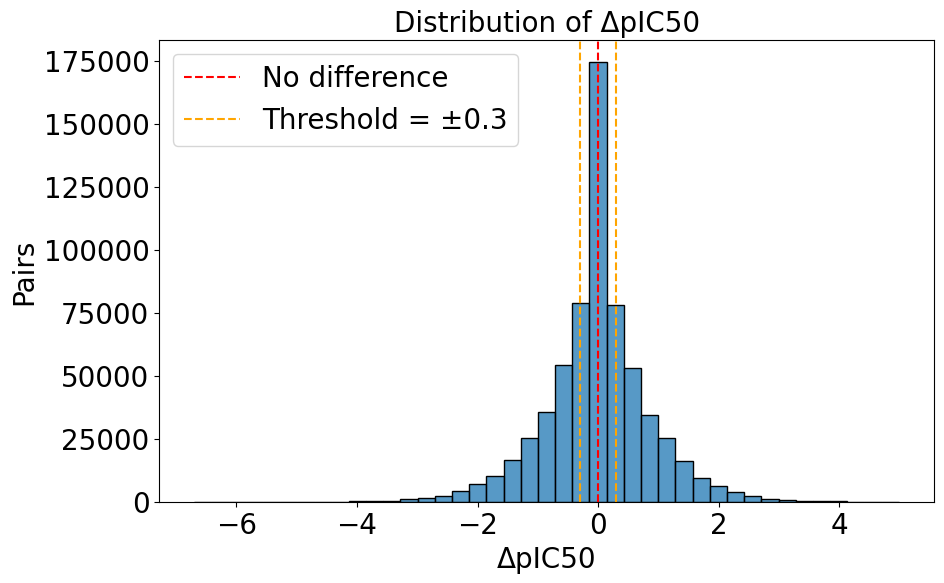

In [19]:
# df_consistent_smilesのdelta_value分布の可視化
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_consistent_smiles = pd.read_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles.csv')
plt.figure(figsize=(10, 6))
sns.histplot(df_consistent_smiles['delta_value'], bins=41, kde=False)
plt.title('Distribution of ΔpIC50', fontsize=20)
plt.xlabel('ΔpIC50', fontsize=20)
plt.ylabel('Pairs', fontsize=20)

# 軸の目盛りの文字サイズも20に
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 点線を追加（=0, =0.3, =-0.3）
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, alpha=1, label='No difference')
plt.axvline(x=0.3, color='orange', linestyle='--', linewidth=1.5, alpha=1, label='Threshold = ±0.3')
plt.axvline(x=-0.3, color='orange', linestyle='--', linewidth=1.5, alpha=1)

# 凡例を左上に追加
plt.legend(loc='upper left', fontsize=20)

plt.show()

In [20]:
#df_consistent_smilesに含まれるペアデータ数、標的数、ユニーク化合物数、アッセイ数を表示
df_consistent_smiles = pd.read_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles.csv')
num_pairs = len(df_consistent_smiles)
num_targets = df_consistent_smiles['TID'].nunique()
num_unique_compounds = pd.unique(df_consistent_smiles[['REF-SMILES', 'PRB-SMILES']].values.ravel()).size
num_assays = df_consistent_smiles['AID'].nunique()
print(f"ペアデータ数: {num_pairs}")
print(f"標的数: {num_targets}")
print(f"ユニーク化合物数: {num_unique_compounds}")
print(f"アッセイ数: {num_assays}")

ペアデータ数: 643937
標的数: 1853
ユニーク化合物数: 107504
アッセイ数: 11948


In [22]:
# df_consistent_smilesのlabel_binごとの件数と%を表示
df_consistent_smiles = pd.read_csv('/gs/bs/tga-ohuelab/masunaga/origin_data_minfrag/dataset_consistentsmiles.csv')
label_bin_counts = df_consistent_smiles['label_bin'].value_counts().sort_index()
print("label_binごとの件数:")
print(label_bin_counts) 
label_bin_percent = df_consistent_smiles['label_bin'].value_counts(normalize=True).sort_index() * 100
print("\nlabel_binごとの割合 (%):")
print(label_bin_percent)

label_binごとの件数:
label_bin
False    379537
True     264400
Name: count, dtype: int64

label_binごとの割合 (%):
label_bin
False    58.940083
True     41.059917
Name: proportion, dtype: float64
